<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Weather-Prediction-LSTM/Weather_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/code/syedali110/weather-prediction-using-rnn/notebook

# Download Dataset

In [1]:
#!/bin/bash
!kaggle datasets download ananthr1/weather-prediction
!unzip weather-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/ananthr1/weather-prediction
License(s): CC-BY-NC-SA-4.0
  0% 0.00/11.5k [00:00<?, ?B/s]
100% 11.5k/11.5k [00:00<00:00, 17.8MB/s]
Archive:  weather-prediction.zip
  inflating: seattle-weather.csv     


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Dataframe

In [3]:
df = pd.read_csv("/content/seattle-weather.csv")
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [5]:
df.isnull().sum()

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [6]:
df.duplicated().sum()

0

# Preparing for Training

In [ ]:
df.head(1)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle


In [8]:
# Correct datatime col
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [9]:
# LabelEncoder
encoder = LabelEncoder()
df['weather'] = encoder.fit_transform(df['weather'])

In [10]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[['precipitation', 'temp_min', 'temp_max', 'wind', 'weather']])
scaled_df = pd.DataFrame(scaled_features, columns=['precipitation', 'temp_min', 'temp_max', 'wind', 'weather'])
scaled_df['date'] = df['date']

In [19]:
features = ['precipitation', 'temp_min', 'wind', 'weather']
target = 'temp_max'
sequence_length = 10
# X, y = df_to_XY(scaled_df, features, target, 10)

X, y = [], []
for i in range(len(scaled_df) - sequence_length):
    X.append(scaled_df[features].iloc[i:i+sequence_length].values)
    y.append(scaled_df[target].iloc[i + sequence_length])

X = np.array(X)
Y = np.array(y)

In [20]:
print(len(X), len(y))

1451 1451


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

In [28]:
print(f"X Train {X_train.shape}")
print(f"X Test: {X_test.shape}")
print(f"Y Train: {Y_train.shape}")
print(f"Y Test: {Y_test.shape}")

X Train (1160, 10, 4)
X Test: (291, 10, 4)
Y Train: (1160,)
Y Test: (291,)


# Define Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [38]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))))
    model.add(Dropout(0.2))
    model.add(LSTM(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for predicting 'temp_max'

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

In [39]:
# Build Model
model = lstm_model((sequence_length, len(features)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,626 (72.76 KB)

 Trainable params: 18,626 (72.76 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, Y_test),
    verbose=1
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1697 - val_loss: 0.0340
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0271 - val_loss: 0.0123
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0202 - val_loss: 0.0111
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - val_loss: 0.0106
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0198 - val_loss: 0.0145
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0180 - val_loss: 0.0110
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0163 - val_loss: 0.0144
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.0130
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0176 - val_loss: 0.0118
Epoch 10/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0166 - val_loss: 0.0130
Epoch 11/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0175 - val_loss: 0.0097
Epoch 12/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0162 - val

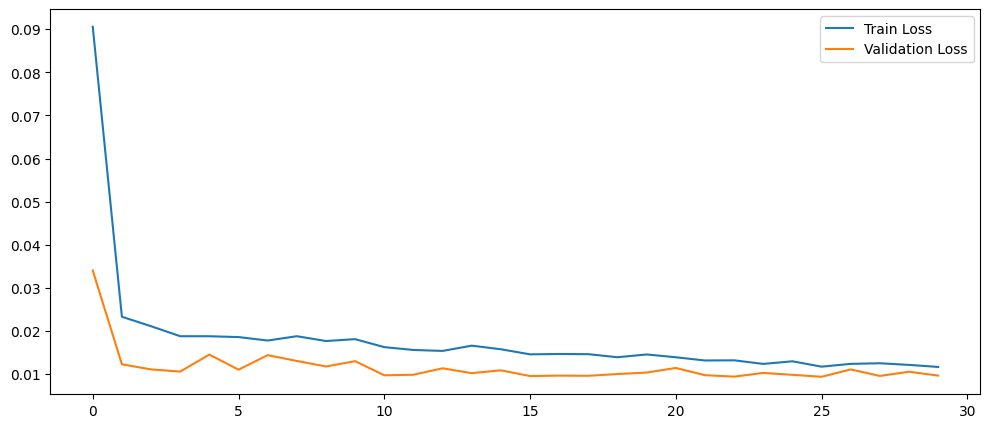

In [41]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()